### DSCI 100: GROUP PROJECT FINAL REPORT
 **Predicting Heart Disease in Hungary**
 > GROUP 10 - SECTION 007: Michelle Ho, Arian Afshari, Zidong Zhou, Kyle Wise

In [37]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)
library(cowplot)

**Introduction:**

> One of the leading causes of death in Hungary are cardiovascular diseases (CVDs) (OECD and WHO, 2017). It constitutes approximately 52.4% of the main diagnoses underlying cause of death and 47.6% of the secondary diagnoses prior to death. Heart failure is a common result of CVDs. Several risk factors are known to be associated with CVDs; the most prominent among them are high blood pressure, high cholesterol levels, and smoking (CDC, 2022). Moreover, susceptibility to heart disease increases with age and other uncontrollable factors such as sex (McLaren, 2023).

> As data science becomes progressively useful in analyzing and interpreting patient outcomes, we plan to use the k-nearest neighbors classification algorithm to predict angiographic disease status of CVDs. Our project will use the *Heart Disease* data set from the UCI Machine Learning Repository to build the model that will predict CVD diagnoses in presenting patients. The diagnosis of heart disease in the data set is defined as a binary label, whether the patient has the disease or not. The disease is present if there is greater than 50% diameter narrowing of any major blood vessels in a patient. Ie., if the value in the num parameter is 1, then more than 50% of the diameter of the major blood vessels are narrowing (Hungarian Institute of Cardiology, 1988). When blood vessels narrow, the heart does not receive the blood that it requries and thus, is considered heart disease.

> The dataset that we will be using features 14 attributes of patients that will be examined to determine which are possible indicators of heart disease:
> - Age
> - Sex
> - Chest pain type (cp); (1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic)
> - Resting blood pressure (trestbps); (mmHg upon admission to hospital)
> - Serum cholestoral (chol); (mg/dl)
> - Fasting blood sugar (fbs) > 120 mg/dl; (1: true; 0: false)
> - Resting electrocardiographic results (restecg); (0: normal, 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2: showing probable or definite left ventricular hypertrophy by Estes' criteria)
> - Maximum heart rate achieved (thalach)
> - Exercise induced angina (exang); (1: yes; 0: no)
> - ST depression induced by exercise relative to rest (oldpeak)
> - Slope of the peak exercise ST segment (slope); (1: upsloping, 2: flat, 3: downsloping)
> - Number of major vessels (0-3) colored by flourosopy (ca)
> - Presence of heart defect (thal): (3: normal; 6: fixed defect; 7: reversable defect)
> - Diagnosis of heart disease (angiographic disease status) (num); (0: < 50% diameter narrowing, 1: > 50% diameter narrowing (the predicted attribute)



**Preliminary data wrangling:**

In [10]:
# setting the seed such that the numbers used in the analysis are reasonably random
set.seed(3789)

In [11]:
# loading the data and mutating the class label column to factor 
heart_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", 
                               col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs","restecg", "thalach", "exang", "oldpeak",
                                             "slope", "ca", "thal", "num"))

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
# converting "?" to NA
heart_disease_data[heart_disease_data == "?"]<-NA

# changing columns to correct type (mutate_if mutates columns based on provided conditions; mutate_at mutates multiple columns to the same type)
heart_disease_data <- heart_disease_data |>
mutate_if(is.character, as.numeric) |>
mutate_at(vars("sex", "cp", "fbs", "restecg", "exang", "ca", "thal", "num", "slope"), factor)
heart_disease_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
28,1,2,130,132,0,2,185,0,0,NA,NA,NA,0
29,1,2,120,243,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,NA,0,0,170,0,0,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,NA,NA,1
58,0,2,180,393,0,0,110,1,1,2,NA,7,1
65,1,4,130,275,0,1,115,1,1,2,NA,NA,1


In [13]:
# partitioning the data into a training (75%) and testing (25%) set; num will be used as the class label
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

**Exploratory data analysis using training data:**

In [14]:
# identifying the proportion of patients with a diagnosis of heart disease (positive angiographic disease status) and the proportion without in the full data
# set and the training data set to ensure that the proportions are preserved during the split
heart_disease_data_proportions <- heart_disease_data |>
                      group_by(diagnosis = num) |>
                      summarize(people = n()) |>
                      mutate(percent = 100*people/nrow(heart_disease_data))
heart_disease_data_proportions

heart_disease_train_proportions <- heart_disease_train |>
                      group_by(diagnosis = num) |>
                      summarize(people = n()) |>
                      mutate(percent = 100*people/nrow(heart_disease_train))
heart_disease_train_proportions

diagnosis,people,percent
<fct>,<int>,<dbl>
0,188,63.94558
1,106,36.05442


diagnosis,people,percent
<fct>,<int>,<dbl>
0,141,64.09091
1,79,35.90909


In [15]:
# table reporting the number of observations in each class of the training data
heart_disease_class_observations <- heart_disease_train |>
                      group_by(diagnosis = num) |>
                      summarize(people = n())
heart_disease_class_observations


# and the number of rows have missing data, at least one NA in the observation
missing_data <- tibble(missing_data = nrow(heart_disease_train[!complete.cases(heart_disease_train),]))
missing_data

diagnosis,people
<fct>,<int>
0,141
1,79


missing_data
<int>
220


In [16]:
# table summarizing the training data including mean, min, and max of the numerical variables
heart_train_summary <- heart_disease_train |>
  summarise(across(
    c(age, trestbps, chol, thalach, oldpeak),
    list(mean = mean, min = min, max = max),
    na.rm = TRUE
  )) |> pivot_longer (everything(), names_to="variable", values_to="value") |> 
 separate(variable, into = c("variable", "statistics"), sep = "_") |> pivot_wider(names_from = statistics, values_from = value)
heart_train_summary

variable,mean,min,max
<chr>,<dbl>,<dbl>,<dbl>
age,48.1090909,28,65
trestbps,132.3287671,92,180
chol,248.9365854,85,603
thalach,139.4155251,82,190
oldpeak,0.5877273,0,5


Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 15 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


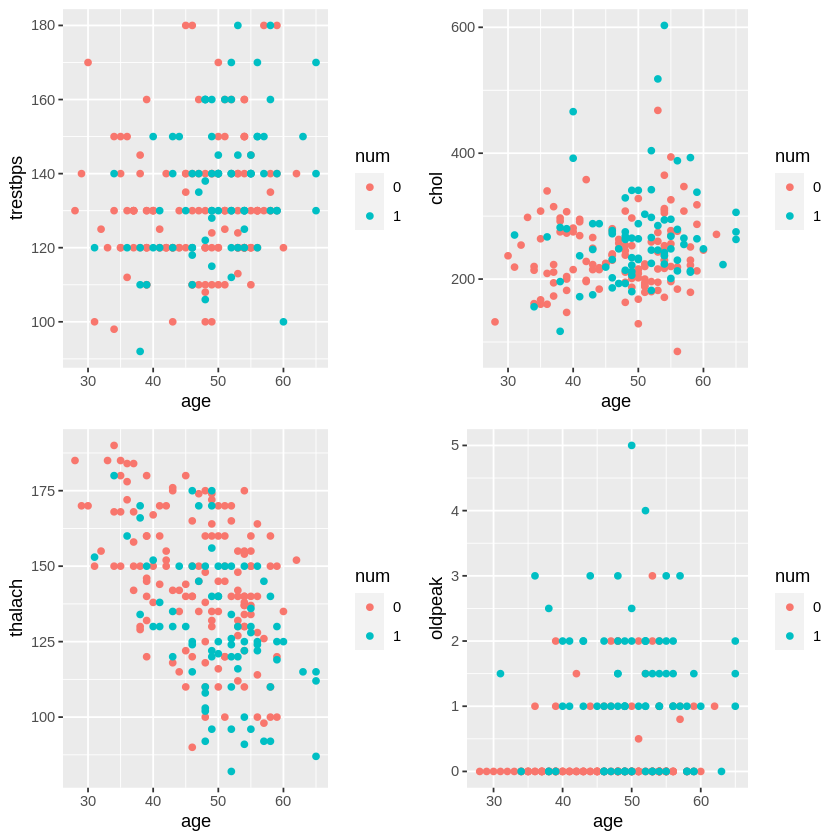

In [39]:
# creating a visulizarion of the dataset that is planned 
#ggplot(heart_disease_train,aes(x=age,y=trestbps,color=num))+geom_point()
plot1<-ggplot(heart_disease_train,aes(x=age,y=trestbps,color=num))+geom_point()
plot2<-ggplot(heart_disease_train,aes(x=age,y=chol,color=num))+geom_point()
plot3<-ggplot(heart_disease_train,aes(x=age,y=thalach,color=num))+geom_point()
plot4<-ggplot(heart_disease_train,aes(x=age,y=oldpeak,color=num))+geom_point()
myplot<-plot_grid(plot1,plot2,plot3,plot4,nrow = 2,ncol=2)
myplot